In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from numpy import arange
from pandas import read_csv
from pandas import set_option
from pandas.tools.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats as st
import itertools
from itertools import chain, combinations
import statsmodels.formula.api as smf
import scipy.stats as scipystats
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats 
import seaborn as sns
from statsmodels.graphics.regressionplots import *
import copy
import math
import time
%matplotlib inline

C:\Users\chads\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 14, 8
sns.set_context("poster")
sns.set_style("whitegrid")

In [3]:
# Downloaded combine csv to my desktop, therefore change directory to my pc desktop
os.chdir('C:\Users\chads\Desktop')

In [4]:
# Import and preview the raw combine data
newdf = pd.read_csv("newdf.csv")
newdf.head()

,position,height,weight,fortyyd,twentyss,threecone,vertical,broad,bench,picktotal
0,RB,69.0,205,4.60,3.95,6.79,42.5,130.0,24.0,54.0
1,WR,72.0,198,4.42,NaN,NaN,NaN,NaN,12.0,20.0
2,RB,72.0,221,4.57,4.10,7.10,39.0,121.0,19.0,149.0
3,OLB,73.0,227,4.55,4.20,7.14,36.0,121.0,24.0,124.0
4,WR,68.0,180,4.43,4.07,6.64,34.0,121.0,13.0,238.0


Create seperate data set for each position, since I believe the players in every position are significantly different

In [5]:
cb = newdf[newdf.position == 'CB']
wr = newdf[newdf.position == 'WR']
c = newdf[newdf.position == 'C']
og = newdf[newdf.position == 'OG']
ot = newdf[newdf.position == 'OT']
qb = newdf[newdf.position == 'QB']
rb = newdf[newdf.position == 'RB']
te = newdf[newdf.position == 'TE']
dt = newdf[newdf.position == 'DT']
de = newdf[newdf.position == 'DE']
olb = newdf[newdf.position == 'OLB']
ilb = newdf[newdf.position == 'ILB']
s = newdf[newdf.position == 'S']

# Missing Values

How I handled missing values is that I removed players from the dataset that had greater than one missing value. After that, I used the mean of every positions attribute to fill in the rest of the missing values. This is one of many reasons why I decided to make a predictive model for every position since there attribute means were so very different as shown. Also, some positions rarely participated in particular drills, therefore will remove that drill from the data set. For instance, only 5 qb's did the bench drill, therefore will removd that drill from the qb data set. 

# Predictive Modeling of every Position

## Position: CB

In [6]:
# Remove players with more than one missing value
cb1= cb.dropna(thresh=9)
# Fill in missing values with the mean of the column
cb= cb1.fillna(cb1.mean())
cb.head()

,position,height,weight,fortyyd,twentyss,threecone,vertical,broad,bench,picktotal
25,CB,72.0,196,4.51,4.07,7.05,40.0,121.0,17.000000,80.0
34,CB,73.0,203,4.48,4.27,6.77,36.0,124.0,14.944444,42.0
41,CB,71.0,193,4.38,4.14,6.94,41.5,129.0,12.000000,50.0
49,CB,69.0,196,4.56,4.15,7.22,35.5,113.0,17.000000,200.0
53,CB,70.0,182,4.50,4.26,7.20,33.5,115.0,9.000000,164.0


In [7]:
# change dataset index to make checking for outliers easier later on..
cb.index = range(len(cb))
cb.head(3)

,position,height,weight,fortyyd,twentyss,threecone,vertical,broad,bench,picktotal
0,CB,72.0,196,4.51,4.07,7.05,40.0,121.0,17.000000,80.0
1,CB,73.0,203,4.48,4.27,6.77,36.0,124.0,14.944444,42.0
2,CB,71.0,193,4.38,4.14,6.94,41.5,129.0,12.000000,50.0


### Check for influential points and outliers

In [8]:
# check r^2 of our data set using OLS prior to removing influential points
lm = smf.ols(formula = "picktotal ~ height + weight + fortyyd + twentyss + threecone + vertical + broad + bench", 
             data = cb).fit()
print(lm.summary())

influence = lm.get_influence()
# For studentized residual, looking for values greater than 2 or less than -2
resid_student = influence.resid_studentized_external

# a point with leverage greater than (2k+2)/n should be carefully examined,
# where k is the number of predictors and n is the number of observations.
# For our example, (2*8+2/227)= 0.07930
leverage = influence.hat_matrix_diag

# Any points greater than 4/n or 4/227=.01762 should be considered 
(cooks, p) = influence.cooks_distance

# The conventional cut-off point for DFFITS is 2*sqrt(k/n)
(dffits, p) = influence.dffits

                            OLS Regression Results                            
Dep. Variable:              picktotal   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.264
Method:                 Least Squares   F-statistic:                     11.16
Date:                Sun, 04 Feb 2018   Prob (F-statistic):           3.38e-13
Time:                        12:18:07   Log-Likelihood:                -1225.9
No. Observations:                 227   AIC:                             2470.
Df Residuals:                     218   BIC:                             2501.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -346.4331    357.175     -0.970      0.3

In [9]:
# Concatenate our original dataset, cb, with our four influential point statistics
cbres = pd.concat([pd.Series(cooks, name = "cooks"), pd.Series(dffits, name = "dffits"), 
                       pd.Series(leverage, name = "leverage"), pd.Series(resid_student, name = "resid_student")], axis = 1)
cbres = pd.concat([cb, cbres], axis = 1)
cbres.head()

,position,height,weight,fortyyd,twentyss,threecone,vertical,broad,bench,picktotal,cooks,dffits,leverage,resid_student
0,CB,72.0,196,4.51,4.07,7.05,40.0,121.0,17.000000,80.0,0.000891,-0.089399,0.036883,-0.456835
1,CB,73.0,203,4.48,4.27,6.77,36.0,124.0,14.944444,42.0,0.002471,-0.149076,0.026565,-0.902411
2,CB,71.0,193,4.38,4.14,6.94,41.5,129.0,12.000000,50.0,0.000184,-0.040606,0.030839,-0.227635
3,CB,69.0,196,4.56,4.15,7.22,35.5,113.0,17.000000,200.0,0.006575,0.243101,0.076691,0.843507
4,CB,70.0,182,4.50,4.26,7.20,33.5,115.0,9.000000,164.0,0.000760,0.082532,0.061721,0.321791


Will use the DFFITS equation to determine which points are infuetial. Can read about the DFFITS and the equation here: https://en.wikipedia.org/wiki/DFFITS

Investigating those points with DFFITS greater than 2 * math.sqrt(float(len(attributes2.columns)) / len(cb))]

In [10]:
# Since DFITS seems to be the best overall measure of influence, will use this measure to determine which data points get removed
attributes = (cb.drop(['position', 'picktotal'],axis=1))
cbres[abs(cbres.dffits) >  2 * math.sqrt(float(len(attributes.columns)) / len(cb))]

,position,height,weight,fortyyd,twentyss,threecone,vertical,broad,bench,picktotal,cooks,dffits,leverage,resid_student
23,CB,71.0,203,4.41,4.27,7.150000,32.5,117.0,17.000000,195.0,0.022465,0.452433,0.052315,1.925625
34,CB,68.0,184,4.55,4.40,7.260000,37.5,124.0,14.000000,41.0,0.047515,-0.658755,0.093216,-2.054621
37,CB,71.0,192,4.63,4.00,6.570000,34.0,117.0,14.944444,254.0,0.023095,0.457838,0.068549,1.687689
44,CB,74.0,185,4.61,4.27,6.970000,34.0,125.0,10.000000,43.0,0.022784,-0.454856,0.065423,-1.719157
50,CB,73.0,187,4.54,4.32,7.170000,36.0,126.0,4.000000,210.0,0.029015,0.513539,0.077050,1.777362
67,CB,70.0,187,4.54,4.03,6.590000,35.0,121.0,16.000000,246.0,0.023131,0.459522,0.048677,2.031470
121,CB,73.0,193,4.50,4.01,6.897703,38.0,127.0,23.000000,179.0,0.016555,0.388072,0.043129,1.827917
128,CB,69.0,171,4.40,4.26,6.897703,34.0,128.0,18.000000,212.0,0.038577,0.594198,0.069977,2.166210
156,CB,70.0,202,4.50,3.97,6.897703,40.0,127.0,17.000000,208.0,0.020730,0.435450,0.039964,2.134262
163,CB,71.0,192,4.39,4.08,6.897703,39.0,115.0,15.000000,215.0,0.025075,0.479387,0.043971,2.235315


r^2 increases by .042, yay!

In [11]:
# Remove these data points from our dataset
newcb= cb.drop(cb.index[[23,34,37,44,50,67,121,128,156,163,224]])
cb=newcb

# Check for an increase in r^2 
lm_1 = smf.ols(formula = "picktotal ~ height + weight + fortyyd + twentyss + threecone + vertical + broad + bench", 
               data = cb).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:              picktotal   R-squared:                       0.333
Model:                            OLS   Adj. R-squared:                  0.307
Method:                 Least Squares   F-statistic:                     12.93
Date:                Sun, 04 Feb 2018   Prob (F-statistic):           4.69e-15
Time:                        12:18:08   Log-Likelihood:                -1148.4
No. Observations:                 216   AIC:                             2315.
Df Residuals:                     207   BIC:                             2345.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -672.0065    348.070     -1.931      0.0

Check attribute distribution using various plots

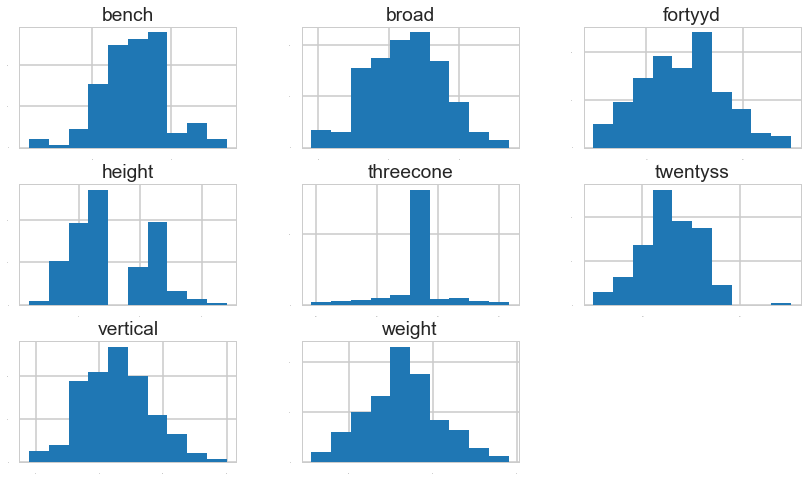

In [12]:
_=attributes.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, layout=(3,3))

Most attributes don't have a gaussian distribution, therefore will have to be standardized

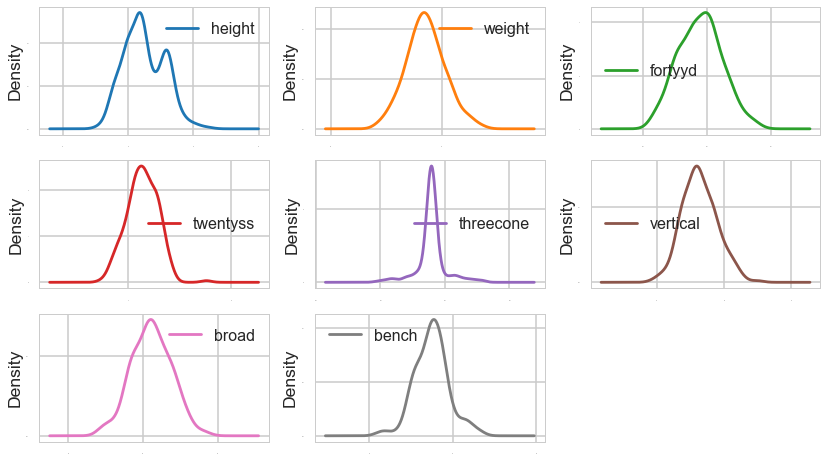

In [13]:
_=attributes.plot(kind='density', subplots=True, layout=(3,3), sharex=False, fontsize=1)

Three cone had a ton of missing values so not surprised there is almost no spread, since we filled in the missing values with mean. Most of the attributes are on different scales, so will have to do a rescale transformation later.

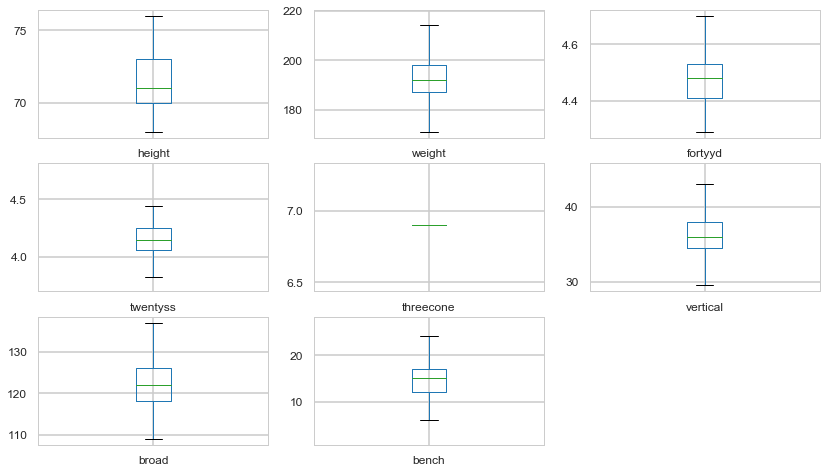

In [14]:
_=attributes.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False,fontsize=12)

### Test different regression algorithms

In [15]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('RIDGE', Ridge()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
models.append(('SVR', SVR()))

In [16]:
array = cb.values
X = array[:,1:9]
Y = array[:,9]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

C:\Users\chads\Anaconda2\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


ScaledLR: -2816.777941 (282.654298)
ScaledLASSO: -2793.337729 (287.154468)
ScaledRIDGE: -2814.273989 (283.602621)
ScaledEN: -2825.852998 (337.170514)
ScaledKNN: -3451.117284 (396.839433)
ScaledCART: -6210.803866 (173.132368)
ScaledSVR: -3801.072976 (532.776741)


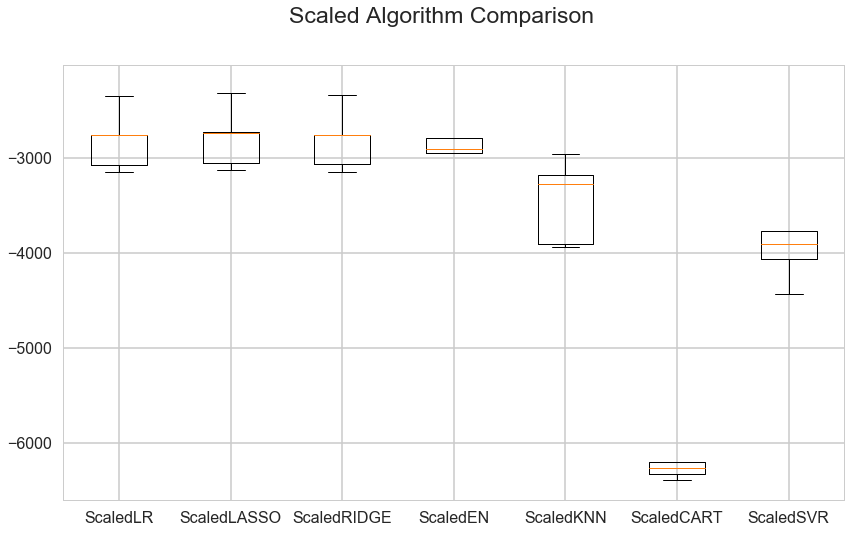

In [17]:
# Test options and evaluation metric
num_folds = 5
seed = 3
scoring = 'neg_mean_squared_error'

# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE',Ridge())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR',SVR())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print (msg)
    
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
_=ax.set_xticklabels(names)

In [18]:
# Grid Search for lasso Tuning to find the best alpha
alphas = np.array([1,0.1,0.01,0.001,0.0001,0])
param_grid = dict(alpha=alphas)
model = Ridge()
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid.fit(X, Y)
print(grid.best_score_)
print(grid.best_estimator_.alpha)

0.258946041463
0.1


In [19]:
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB',AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM',GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET',ExtraTreesRegressor())])))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledAB: -2998.287873 (314.849627)
ScaledGBM: -3458.813393 (502.475206)
ScaledRF: -3269.846049 (690.672055)
ScaledET: -3345.463948 (441.558722)


Lasso is the winner!

In [20]:
# prepare the Lasso model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = Lasso(random_state=seed, alpha = 0.1)
model.fit(rescaledX, Y_train)

# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
mse_score_model = mean_squared_error(Y_validation, predictions)
r2_score_model = r2_score(Y_validation, predictions)
print "Lasso MSE on test data : %f" % mse_score_model
print "Lasso r^2 on test data : %f" % r2_score_model

Lasso MSE on test data : 1975.610427
Lasso r^2 on test data : 0.399610


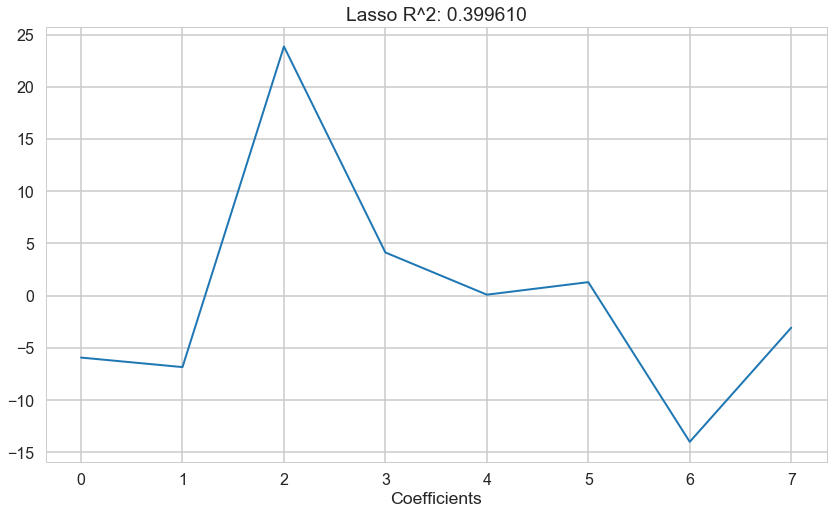

In [21]:
plt.plot(model.coef_, linewidth=2, label='Lasso coefficients')
plt.title("Lasso R^2: %f"% (r2_score_model))
_=plt.xlabel("Coefficients")

fortyyd coefficient carries the most weight out of all eight coefficients

In [22]:
# Matching lasso coefficient values to the column labels
cblabels = (cb.drop(['position','picktotal'],axis=1))
pd.DataFrame({'features': cblabels.columns, 'estimatedCoefficients': model.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,height,-5.930203
1,weight,-6.841750
2,fortyyd,23.854433
3,twentyss,4.131691
4,threecone,0.092134
5,vertical,1.290818
6,broad,-13.997168
7,bench,-3.069914


In [23]:
# Model intercept and the number of coefficients
print 'Estimated intercept coefficient: {}'.format(model.intercept_)
print 'Number of coefficients: {}'.format(len(model.coef_))

Estimated intercept coefficient: 100.819767442
Number of coefficients: 8


Model not even close at predicting the round a player gets drafted. 256 is the highest picktotal a player can get drafted and the model is extremely off.

In [24]:
# Make 5 predictions with the model and, well, just bad
model.predict(X)[0:5]

array([-3236.30198736, -3330.88393321, -3307.36006978, -3110.80380076,
       -3027.94477892])

Well, that wasn't very pretty, let's try another position.

## Position: WR

In [25]:
# Remove players with more than one missing value
wr1= wr.dropna(thresh=9)
# Fill in missing values with the mean of the column
wr = wr1.fillna(wr1.mean())
wr.head()

,position,height,weight,fortyyd,twentyss,threecone,vertical,broad,bench,picktotal
4,WR,68.0,180,4.43,4.07,6.64,34.0,121.0,13.0,238.0
15,WR,73.0,197,4.42,4.15,6.66,41.5,129.0,7.0,162.0
19,WR,72.0,205,4.54,4.11,7.04,37.0,120.0,17.0,233.0
29,WR,70.0,195,4.51,4.26,6.97,33.0,113.0,10.0,184.0
31,WR,73.0,212,4.43,4.06,6.98,41.0,131.0,23.0,87.0


In [26]:
# change dataset index to make checking for outliers easier later on..
wr.index = range(len(wr))
wr.head(3)

,position,height,weight,fortyyd,twentyss,threecone,vertical,broad,bench,picktotal
0,WR,68.0,180,4.43,4.07,6.64,34.0,121.0,13.0,238.0
1,WR,73.0,197,4.42,4.15,6.66,41.5,129.0,7.0,162.0
2,WR,72.0,205,4.54,4.11,7.04,37.0,120.0,17.0,233.0


### Check for influential points

In [27]:
# check r^2 of our data set using OLS prior to removing influential points
lm = smf.ols(formula = "picktotal ~ height + weight + fortyyd + twentyss + threecone + vertical + broad + bench", 
             data = wr).fit()
print(lm.summary())

influence = lm.get_influence()
# For studentized residual, looking for values greater than 2 or less than -2
resid_student = influence.resid_studentized_external

# a point with leverage greater than (2k+2)/n should be carefully examined,
# where k is the number of predictors and n is the number of observations.
# For our example, (2*8+2/227)= 0.07930
leverage = influence.hat_matrix_diag

# Any points greater than 4/n or 4/227=.01762 should be considered 
(cooks, p) = influence.cooks_distance

# The conventional cut-off point for DFFITS is 2*sqrt(k/n)
(dffits, p) = influence.dffits

                            OLS Regression Results                            
Dep. Variable:              picktotal   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.034
Method:                 Least Squares   F-statistic:                     1.892
Date:                Sun, 04 Feb 2018   Prob (F-statistic):             0.0632
Time:                        12:18:16   Log-Likelihood:                -1141.5
No. Observations:                 203   AIC:                             2301.
Df Residuals:                     194   BIC:                             2331.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -321.2446    406.328     -0.791      0.4

In [28]:
# Concatenate our original dataset, wr, with our four influential point statistics
wrres = pd.concat([pd.Series(cooks, name = "cooks"), pd.Series(dffits, name = "dffits"), 
                       pd.Series(leverage, name = "leverage"), pd.Series(resid_student, name = "resid_student")], axis = 1)
wrres = pd.concat([wr, wrres], axis = 1)
wrres.head()

,position,height,weight,fortyyd,twentyss,threecone,vertical,broad,bench,picktotal,cooks,dffits,leverage,resid_student
0,WR,68.0,180,4.43,4.07,6.64,34.0,121.0,13.0,238.0,0.017128,0.395079,0.043489,1.852853
1,WR,73.0,197,4.42,4.15,6.66,41.5,129.0,7.0,162.0,0.004860,0.208951,0.062169,0.811560
2,WR,72.0,205,4.54,4.11,7.04,37.0,120.0,17.0,233.0,0.005755,0.228477,0.020363,1.584745
3,WR,70.0,195,4.51,4.26,6.97,33.0,113.0,10.0,184.0,0.001550,0.117944,0.030883,0.660695
4,WR,73.0,212,4.43,4.06,6.98,41.0,131.0,23.0,87.0,0.000001,0.003211,0.049735,0.014034


In [29]:
# Since DFITS seems to be the best overall measure of influence, will use this measure to determine which data points get removed
wrattributes = (wr.drop(['picktotal'],axis=1))
wrres[abs(wrres.dffits) >  2 * math.sqrt(float(len(wrattributes.columns)) / len(wr))]

,position,height,weight,fortyyd,twentyss,threecone,vertical,broad,bench,picktotal,cooks,dffits,leverage,resid_student
25,WR,71.00,198,4.43,3.94,6.690000,38.5,122.0,7.000000,12.0,0.019879,-0.424846,0.062358,-1.647416
35,WR,75.00,219,4.42,3.98,6.640000,37.5,123.0,20.000000,236.0,0.023207,0.461275,0.043924,2.152056
40,WR,70.00,163,4.46,4.18,6.630000,41.0,132.0,14.708333,240.0,0.050294,0.678330,0.098537,2.051700
44,WR,68.00,174,4.34,4.01,6.898287,32.0,120.0,14.000000,8.0,0.020009,-0.425732,0.074314,-1.502568
60,WR,75.00,194,4.51,4.33,6.650000,34.5,122.0,7.000000,236.0,0.023001,0.457079,0.069533,1.672039
69,WR,73.00,225,4.53,3.98,6.590000,35.0,124.0,21.000000,238.0,0.033692,0.555326,0.066932,2.073419
84,WR,70.25,196,4.61,4.18,6.930000,38.5,121.0,4.000000,20.0,0.038706,-0.594968,0.078842,-2.033680
114,WR,65.00,166,4.34,4.48,6.540000,42.0,116.0,10.000000,197.0,0.039952,0.600706,0.175890,1.300271
139,WR,76.00,218,4.43,4.33,7.040000,32.0,116.0,9.000000,243.0,0.021219,0.439874,0.051565,1.886487
143,WR,73.00,184,4.31,4.11,6.620000,41.5,129.0,7.000000,253.0,0.052232,0.694084,0.076527,2.411108


Increased our r^2 by 6.8%, after removing infuential points

In [30]:
# Remove these data points from our dataset
newwr= wr.drop(wr.index[[25,35,40,44,60,69,84,114,139,143,192]])
wr=newwr

# Check for an increase in r^2 
lm_1 = smf.ols(formula = "picktotal ~ height + weight + fortyyd + twentyss + threecone + vertical + broad + bench", 
               data = wr).fit()
print(lm_1.summary())

                            OLS Regression Results                            
Dep. Variable:              picktotal   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     3.737
Date:                Sun, 04 Feb 2018   Prob (F-statistic):           0.000448
Time:                        12:18:16   Log-Likelihood:                -1063.0
No. Observations:                 192   AIC:                             2144.
Df Residuals:                     183   BIC:                             2173.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -466.3839    394.911     -1.181      0.2

### Try different regression algorithms

In [31]:
array = wr.values
X = array[:,1:9]
Y = array[:,9]
validation_size = 0.20
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

ScaledLR: -4702.531640 (635.003237)
ScaledLASSO: -4516.522447 (524.533130)
ScaledRIDGE: -4680.807257 (614.926546)
ScaledEN: -4335.937381 (539.003545)
ScaledKNN: -5473.286452 (1093.470044)
ScaledCART: -9684.084731 (958.974919)
ScaledSVR: -4760.681899 (811.416382)


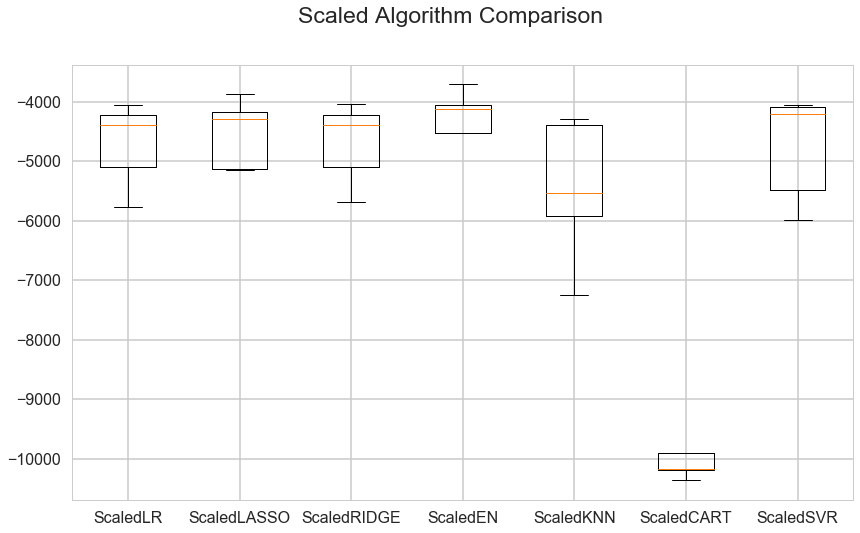

In [32]:
# Test options and evaluation metric
num_folds = 5
seed = 3
scoring = 'neg_mean_squared_error'

# Standardize the dataset
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO',Lasso())])))
pipelines.append(('ScaledRIDGE', Pipeline([('Scaler', StandardScaler()),('RIDGE',Ridge())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN',ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN',KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART',DecisionTreeRegressor())])))
pipelines.append(('ScaledSVR', Pipeline([('Scaler', StandardScaler()),('SVR',SVR())])))
results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
_=ax.set_xticklabels(names)

In [33]:
# Gridsearch for Elastic net tuning
l1_space = np.linspace(0, 1, 30)
param_grid = {'l1_ratio': l1_space}
model = ElasticNet()# Grid Search for Elastic net Tuning

grid = GridSearchCV(model, param_grid, cv=5)
grid.fit(X, Y)
print("Tuned ElasticNet l1 ratio: {}".format(grid.best_params_))

C:\Users\chads\Anaconda2\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Tuned ElasticNet l1 ratio: {'l1_ratio': 0.0}


ScaledAB: -5024.630522 (436.957828)
ScaledGBM: -5848.188293 (657.584291)
ScaledRF: -5553.461116 (501.885590)
ScaledET: -5640.743912 (454.859170)


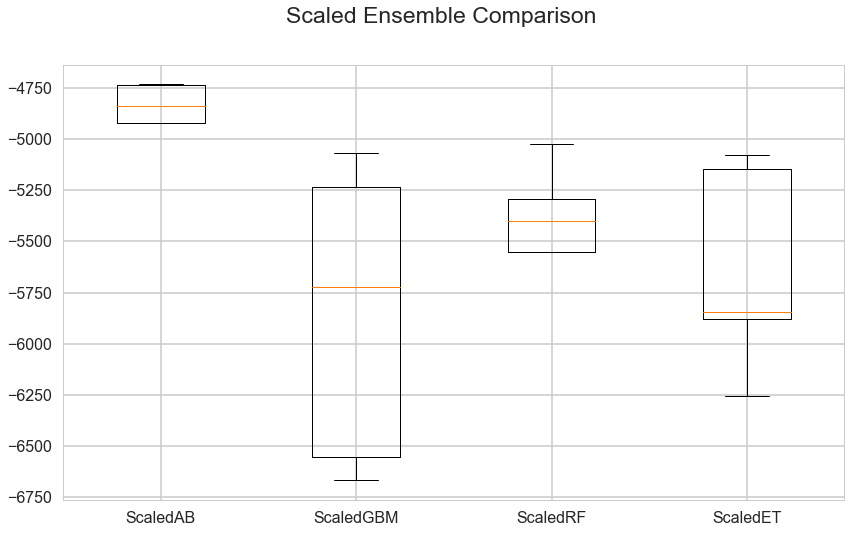

In [34]:
# ensembles
ensembles = []
ensembles.append(('ScaledAB', Pipeline([('Scaler', StandardScaler()),('AB',AdaBoostRegressor())])))
ensembles.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM',GradientBoostingRegressor())])))
ensembles.append(('ScaledRF', Pipeline([('Scaler', StandardScaler()),('RF',RandomForestRegressor())])))
ensembles.append(('ScaledET', Pipeline([('Scaler', StandardScaler()),('ET',ExtraTreesRegressor())])))
results = []
names = []
for name, model in ensembles:
    kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
    
# Compare Algorithms
fig = plt.figure()
fig.suptitle('Scaled Ensemble Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
_=ax.set_xticklabels(names)

Just god awful results. WR combine numbers have no predictive powers for picktotal

In [35]:
# prepare the elasticnet model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model1 = ElasticNet(random_state=seed, l1_ratio = 1)
model1.fit(rescaledX, Y_train)

# transform the validation dataset
rescaledValidationX = scaler.transform(X_validation)
predictions = model1.predict(rescaledValidationX)
mse_score_model1 = mean_squared_error(Y_validation, predictions)
r2_score_model1 = r2_score(Y_validation, predictions)
print("ElasticNet MSE on test data : %f" % mse_score_model1)
print("ElasticNet r^2 on test data : %f" % r2_score_model1)

ElasticNet MSE on test data : 3794.176492
ElasticNet r^2 on test data : -0.076686


Forty yard dash carries the most weight

In [36]:
# Matching coefficient values to the column labels
wrlabels = (wr.drop(['position','picktotal'],axis=1))
pd.DataFrame({'features': wrlabels.columns, 'estimatedCoefficients': model1.coef_})[['features', 'estimatedCoefficients']]

,features,estimatedCoefficients
0,height,-3.722376
1,weight,-9.849209
2,fortyyd,16.903231
3,twentyss,-0.848136
4,threecone,8.690016
5,vertical,-2.324810
6,broad,-4.446575
7,bench,-4.543225


In [37]:
# Model intercept and the number of coefficients
print 'Estimated intercept coefficient: {}'.format(model1.intercept_)
print 'Number of coefficients: {}'.format(len(model1.coef_))

Estimated intercept coefficient: 113.908496732
Number of coefficients: 8


With such a terrible r^2 and MSE, I am not going to even try making predictions with this model

# Pump the brakes on this regression project!

Let's face it, our regression models for positions CB and WR have aweful MSE and r^2 scores, so instead of continuing on with more terrible models for the next 11 positions, let's change things.

I probably had a little bias by thinking we had to create 13 seperate models due to the positions having different means for the attributes. I'm also a football fan and know that guys playing the positions are much different as in size, speed, etc., which may cause some bias in my analysis.

What if I wasn't a football fan? I would have no idea what column position means. As a data scientist, all I would know is that the position column is a categorical variable and to use it appropriately by turning it into dummy variables.

If you remember, after we eliminated players from the dataset that were NOT drafted, we ended up with 3133 rows (players). We then split up those 3133 players into the 13 different positions and tried to predict what their picktotal would be which could range from 1-256. With the little data that we have, trying to make a prediction of a value between 1-256 just seams way to granular. We are drilling to deep. It's time to bring the drill up some and make this less granular.

So, we will now reintroduce the players that were not drafted back into our dataset, which will give us our original player count of 4822 players. We will also make this study less granular by just simply predicting if a player will be drafted yes or no. We will now continue this project as a classification project, which is the final section of this project. 

HINT!! Before you think this project is junk and don't go on to the next section, it does get better!